# Audio Model Creation and Quantization

This notebook demonstrates the process of training, quantizing, and evaluating audio models. The workflow includes:

1. Auto Model Generation
2. Model Training and Pruning
3. Quantization (Post-Training and Quantization-Aware)
4. Evaluation of Quantized Models
5. Analysis of Model Size vs. Accuracy

## SCC stuff

In [1]:
#when using scc and selecting jupyter modules use these in this order
#python3/3.10.12 tensorflow/2.11.0

# Imports and GPU


In [2]:
# Import basic functionality libraries
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tempfile
import shutil
import sys
import gc
import zipfile
import re
from sklearn.model_selection import train_test_split
# More specific tf import such as autotuner
from tensorflow.keras import layers
from IPython import display
import keras_tuner as kt
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dense, Activation, Input, Reshape, Multiply, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, ReLU, Dropout
from tensorflow.keras import Sequential

# Libraries for model optimizations
import tensorflow_model_optimization as tfmot
#from tensorflow_model_optimization.python.core.keras.compat import keras
from keras.layers import Resizing
from tensorflow_model_optimization.quantization.keras import quantize_annotate_layer
import nbimporter
#import tf_keras as keras #this one worked for local

In [3]:
# for SCC
import tensorflow.keras as keras

## Setup tensorflow GPU support

In [4]:
use_gpu = True # set it here by hand

if use_gpu:
    # Check if GPU is available
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
    else:
        print("No GPU available")

1 Physical GPUs, 1 Logical GPUs


# Run .py preprocessing that sets up the datasets

The code below imports the datasets from serealized TFREcords, batches them, and results in the final train/test/val_spectrogram_ds datasets.

In [107]:
# Specify the path to your output dir|ectory where the .npy files are saved
output_dir = 'processed_dataset_small'  # Replace with your actual output directory

# Load the features and labels
features = np.load(os.path.join(output_dir, 'features.npy'))
labels = np.load(os.path.join(output_dir, 'labels.npy'))

print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

Features shape: (271086, 49, 40)
Labels shape: (271086,)


In [108]:
# Expand dimensions to add a channel dimension
features = np.expand_dims(features, -1)  # Shape becomes (num_samples, num_frames, num_mel_bins, 1)

# Split data into training + validation and test sets (80% training + validation, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels)

# Further split the training + validation set into training and validation sets (60% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Training set shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Test set shape: {X_test.shape}, Labels shape: {y_test.shape}")

Training set shape: (162651, 49, 40, 1), Labels shape: (162651,)
Validation set shape: (54217, 49, 40, 1), Labels shape: (54217,)
Test set shape: (54218, 49, 40, 1), Labels shape: (54218,)


In [109]:
np.unique(y_train)

array([0, 1, 2, 3])

In [110]:
# Compute mean and standard deviation from the training data
mean = np.mean(X_train)
std = np.std(X_train)

print(f"Training data mean: {mean:.4f}, standard deviation: {std:.4f}")

# Normalize the training data
X_train_norm = (X_train - mean) / std

# Normalize the validation data
X_val_norm = (X_val - mean) / std

# Normalize the test data
X_test_norm = (X_test - mean) / std



Training data mean: -4.7196, standard deviation: 5.2118


In [111]:
def serialize_example(image, label):
    """Creates a tf.train.Example message ready to be written to a file."""
    image = tf.cast(image * 255, tf.uint8)  # Scale to [0, 255] and cast to uint8
    jpeg_image = tf.image.encode_jpeg(image)  # Encode image as JPEG
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[jpeg_image.numpy()])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def write_tfrecord(filename, images, labels):
    with tf.io.TFRecordWriter(filename) as writer:
        for image, label in zip(images, labels):
            serialized_example = serialize_example(image, label)
            writer.write(serialized_example)
    print(f"TFRecord file created: {filename}")

# Step 3: Write each dataset to a separate TFRecord file
write_tfrecord('train_spec_ds.tfrecord', X_train_norm, y_train)
write_tfrecord('val_spec_ds.tfrecord', X_val_norm, y_val)
write_tfrecord('test_spec_ds.tfrecord', X_test_norm, y_test)

TFRecord file created: train_spec_ds.tfrecord
TFRecord file created: val_spec_ds.tfrecord
TFRecord file created: test_spec_ds.tfrecord


In [112]:
# Function to parse a single serialized example from TFRecord
def _parse_function(proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),  # Image is stored as a string
        'label': tf.io.FixedLenFeature([], tf.int64),   # Label is an float32
    }
    
    # Parse the input `tf.train.Example` proto using the feature description
    parsed_example = tf.io.parse_single_example(proto, feature_description)
    
    # Decode the JPEG-encoded image back into a float32 tensor
    image = tf.io.decode_jpeg(parsed_example['image'], channels=1)  # Grayscale
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to [0, 1] range
    
    # Reshape the image to its new shape (e.g., [1, 1960])
    image = tf.reshape(image, [1960,])
    
    # Get the label
    label = parsed_example['label']
    
    return image, label

In [113]:
# Function to load the dataset from a TFRecord file
def load_dataset(tfrecord_file, batch_size=64):
    # Load the TFRecord file
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
    
    # Parse the serialized data using the _parse_function
    parsed_dataset = raw_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch and shuffle the dataset (optional, depending on your needs) buffer_size is not size of batch its size of buffer
    parsed_dataset = parsed_dataset.shuffle(buffer_size=1000).batch(batch_size)
    parsed_dataset = parsed_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return parsed_dataset

In [114]:
# Load the train, test, and validation datasets from TFRecord files
train_spectrogram_ds = load_dataset('train_spec_ds.tfrecord')
test_spectrogram_ds = load_dataset('test_spec_ds.tfrecord')
val_spectrogram_ds = load_dataset('val_spec_ds.tfrecord')

In [115]:
new_size = len(list(train_spectrogram_ds))
print(f"New dataset size: {new_size}")

# Get input shape and number of classes
for spectrograms, labels in train_spectrogram_ds.take(1):
    input_shape = spectrograms.shape
    input_type = spectrograms.dtype 
    label_shape = labels.shape
    label_type = labels.dtype
    print('Input shape:', input_shape)
    print('Input type:', input_type)
    print('Label shape:', label_shape)
    print('Label type:', label_type)
    

New dataset size: 2542
Input shape: (64, 1960)
Input type: <dtype: 'float32'>
Label shape: (64,)
Label type: <dtype: 'int64'>


In [116]:
new_size = len(list(test_spectrogram_ds))
print(f"New dataset size: {new_size}")

New dataset size: 848


In [117]:
import collections

def count_labels(dataset):
    label_counts = collections.Counter()
    for images, labels in dataset:
        # Convert labels to a NumPy array and update counts
        label_values = labels.numpy()
        label_counts.update(label_values)
    return label_counts

train_label_counts = count_labels(train_spectrogram_ds)
val_label_counts = count_labels(val_spectrogram_ds)
test_label_counts = count_labels(test_spectrogram_ds)

print("Training label counts:", train_label_counts)
print("Validation label counts:", val_label_counts)
print("Test label counts:", test_label_counts)    

Training label counts: Counter({0: 60256, 1: 54386, 2: 24009, 3: 24000})
Validation label counts: Counter({0: 20086, 1: 18128, 2: 8003, 3: 8000})
Test label counts: Counter({0: 20086, 1: 18129, 2: 8003, 3: 8000})


# macros!! important for deployable model creation

In [118]:
# features_min = 0.0
# features_max = 26.0
SAMPLE_RATE = 16000
CLIP_DURATION_MS = 1000
WINDOW_SIZE_MS = 30.0
FEATURE_BIN_COUNT = 40
WINDOW_STRIDE = 20
NUM_LABELS = 4

# QUANT_INPUT_MIN = 0.0
# QUANT_INPUT_MAX = 26.0
# QUANT_INPUT_RANGE = QUANT_INPUT_MAX - QUANT_INPUT_MIN

# average_window_width = -1
# fingerprint_width = feature_bin_count

fingerprint_min = 0.0
fingerprint_max = 26.0

In [119]:
desired_samples = int(SAMPLE_RATE * CLIP_DURATION_MS / 1000)
window_size_samples = int(SAMPLE_RATE * WINDOW_SIZE_MS / 1000)
window_stride_samples = int(SAMPLE_RATE * WINDOW_STRIDE / 1000)
length_minus_window = (desired_samples - window_size_samples)

if length_minus_window < 0:
    spectrogram_length = 0
else:
    spectrogram_length = 1 + int(length_minus_window / window_stride_samples)
    
average_window_width = -1
fingerprint_width = FEATURE_BIN_COUNT

In [120]:
fingerprint_size = fingerprint_width * spectrogram_length

In [121]:
inputs = tf.keras.Input(shape=(fingerprint_size,), dtype=tf.float32, name='fingerprint_input')

# Apply the fake quant operation directly
fingerprint_input = tf.quantization.fake_quant_with_min_max_args(inputs, 
                                                                 fingerprint_min, 
                                                                 fingerprint_max)

# Keras Autotuner

The below functions uses keras autotuner to generate models of a general shape defined in the AutoTuner.build_model  
and saves the models if their sizes and accuracies meet some thresholds.
The training output is truncated so that on the SCC the training can be faster.  
The code works on the SCC but for whatever reason I keep running into a CPU memory overflow even tho I  
specifically delete the history of models and train in batches. We can work to fix this but I already generated   
about a hundred models so it is not a priority.

In [ ]:
from keras_tuner import errors

In [ ]:
import audio_models
import logging
from contextlib import contextmanager

no_logs = False # set to false to see printouts of models during training

#class CustomLogger(logging.Logger):
#    def __init__(self, name, level=logging.ERROR):  # Only log errors
#        super().__init__(name, level)
        
# Suppress Keras Tuner logger
logging.getLogger("keras_tuner").setLevel(logging.CRITICAL)

if no_logs:
    # Suppress TensorFlow and Keras Tuner logs
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs
    tf.get_logger().setLevel(logging.ERROR)  # Suppress TensorFlow's Python warnings
    logging.getLogger("keras_tuner").setLevel(logging.CRITICAL)  # Suppress Keras Tuner logs


@contextmanager
def suppress_output():
    """
    Suppress all output to stdout and stderr.
    """
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def run_with_iteration_display(autotuner, train_data, val_data, num_epochs, max_trials):
    """
    Run the tuner with suppressed output, but display the current iteration number.
    """
    for current_trial in range(1, max_trials + 1):
        # Print the current trial number outside the suppress_output context
        print(f"\rTraining model {current_trial} out of {max_trials}...", end="", flush=True)

        # Suppress all other outputs during the trial
        with suppress_output():
            try:
                autotuner.run_tuner(train_data, val_data, num_epochs)
            except RuntimeError as e:
                # Handle errors gracefully without terminating the loop
                print(f"\nError encountered during trial {current_trial}: {str(e)}")
                continue
                
    # Access and display the number of saved models
    saved_model_count = autotuner.tuner.saved_model_count
    print(f"\nTraining complete. Saved {saved_model_count} models that fit the criteria.")

In [ ]:
class CustomRandomSearch(kt.RandomSearch):
    def __init__(self, *args, save_dir=None, parameter_threshold=None, accuracy_threshold=None, oracle = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.save_dir = save_dir
        self.parameter_threshold = parameter_threshold
        self.accuracy_threshold = accuracy_threshold
        os.makedirs(self.save_dir, exist_ok=True)
        self.saved_model_count = 0  # Counter for saved models

    def run_trial(self, trial, *fit_args, **fit_kwargs):
        current_trial = int(trial.trial_id) + 1
        total_trials = self.oracle.max_trials
        print(f"\rTraining model {current_trial} of {total_trials}", end="")  

        model = self.hypermodel.build(trial.hyperparameters)
        if hasattr(model, 'is_invalid') and model.is_invalid:
            # For invalid models, return a fixed low score without training
            self.oracle.update_trial(
                trial.trial_id, {'val_accuracy': float('-inf')}
            )
            return

        # Add early stopping callback to fit_kwargs
        callbacks = fit_kwargs.get('callbacks', [])
        callbacks.extend([
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                min_delta=0.01,
                patience=3,
                restore_best_weights=True,
                verbose=0 #1
            )
        ])
        fit_kwargs['callbacks'] = callbacks

        # Train the model
        history = model.fit(*fit_args, **fit_kwargs, verbose = 0)

        # Extract the best validation accuracy
        val_accuracy = max(history.history.get('val_accuracy', [0]))
        num_params = model.count_params()

        # Save the model if thresholds are met
        if val_accuracy > self.accuracy_threshold and num_params < self.parameter_threshold:
            model_save_path = os.path.join(
                self.save_dir,
                f"model_trial_{trial.trial_id}_acc_{int(val_accuracy * 100)}_params_{num_params}.keras"
            )
            model.save(model_save_path)
            print(f"Saved model from trial {trial.trial_id} with accuracy: {val_accuracy:.2f} and params: {num_params}")
            self.saved_model_count += 1
            del model
            gc.collect()

        # Report the metric to the tuner
        self.oracle.update_trial(
            trial.trial_id, {'val_accuracy': val_accuracy}
        )

In [ ]:
class AutoTuner:
    def __init__(self, tuner_dir, save_dir, parameter_threshold, accuracy_threshold, max_trials=10, executions_per_trial=1):
        self.tuner_dir = tuner_dir
        self.save_dir = save_dir
        self.parameter_threshold = parameter_threshold
        self.accuracy_threshold = accuracy_threshold
        self.max_trials = max_trials
        self.executions_per_trial = executions_per_trial

        # Clean up the tuner directory if it already exists
        if os.path.exists(self.tuner_dir):
            shutil.rmtree(self.tuner_dir)
            
        # Create the oracle with a custom limit for consecutive failures
        oracle = kt.oracles.RandomSearchOracle(
            objective=kt.Objective("val_accuracy", direction="max"),
            max_consecutive_failed_trials=100  # Adjust as needed
        )

        # Initialize the tuner
        self.tuner = CustomRandomSearch(
            self.build_model,
            oracle=oracle,
            max_trials=self.max_trials,
            executions_per_trial=self.executions_per_trial,
            directory=self.tuner_dir,
            overwrite=True,  # Overwrite results to free memory
            project_name='model_tuning',
            save_dir=self.save_dir,
            parameter_threshold=self.parameter_threshold,
            accuracy_threshold=self.accuracy_threshold,
        )

    def build_model(self, hp):
        """
        Build model with validation checks that allow skipping invalid configurations.
        """
        input_frequency_size = FEATURE_BIN_COUNT
        input_time_size = spectrogram_length
        label_count = NUM_LABELS
        
        model = tf.keras.Sequential()
        input_shape = (49, 40, 1)
        
        # Input layer
        model.add(layers.Input(shape=(input_time_size * input_frequency_size,), name='input'))
        
        #add reshape layer
        model.add(
            layers.Reshape((input_time_size, input_frequency_size, 1), name='reshape')
        )
        
        
        current_height, current_width = input_shape[0], input_shape[1]
        is_valid = True

        # Convolutional layers with tunable filters, kernel size, and stride
        for i in range(hp.Int('num_conv_layers', 1, 3)):
            kernel_size = hp.Choice(f'kernel_size_{i}', values=[6, 8, 10, 12])
            stride = hp.Choice(f'stride_{i}', values=[2, 4, 8, 10, 12])
            
            # Calculate new spatial dimensions
            new_height = (current_height - kernel_size) // stride + 1
            new_width = (current_width - kernel_size) // stride + 1
            
            # Check if dimensions are valid
            if new_height <= 0 or new_width <= 0:
                print(f"Invalid configuration at layer {i}: kernel_size={kernel_size}, stride={stride}, input_shape=({current_height}, {current_width})")
                is_valid = False
                break

            # Add convolutional layer if valid
            model.add(layers.Conv2D(
                filters=hp.Int(f'filters_{i}', min_value=6, max_value=12, step=2),
                kernel_size=kernel_size,
                strides=stride,
                activation='relu'
            ))
            model.add(layers.Dropout(rate=hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3])))

            # Update current dimensions
            current_height, current_width = new_height, new_width

        # If dimensions are invalid, return an invalid model
        if not is_valid:
            model.is_invalid = True
            return model

        # Add dropout here or at the end of every conv iteration
        #model.add(layers.Dropout(rate=hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3])))

        # Flatten layer
        model.add(layers.Flatten())

        # Output layer
        model.add(layers.Dense(label_count, activation='softmax'))

        model_params = model.count_params()
        if model_params > self.parameter_threshold:
            print(f"Model exceeds parameter limit: {model_params} params")
            model.is_invalid = True
        else:
            # Compile the model
            model.compile(
                optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3])),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )
            model.is_invalid = False

        return model


    def run_tuner(self, train_data, val_data, num_epochs):
        """
        Run the tuner to search for the best model.
        """
        self.tuner.search(train_data, validation_data=val_data, epochs=num_epochs)
        print(f"\nTraining complete. Saved {self.tuner.saved_model_count} models that fit the criteria.")

In [ ]:
# you can remove the wrapper run_with_iteration_display and just call the autotuner for full training output
parameter_threshold = 100000 # Model sizes will be below this threshold
accuracy_threshold = 0.90 # Models must have validation accuracy above this threshold
num_epochs = 10
max_trials = 12
tuner_dir = 'autotuner_dir'
save_dir = "saved_models"
batch_size = 4

# Instantiate and run the AutoTuner
for batch in range(0, max_trials, batch_size):
    print(f"Running trials {batch + 1} to {batch + batch_size}")
    autotuner = AutoTuner(tuner_dir, save_dir, parameter_threshold, accuracy_threshold, max_trials=batch_size)
    run_with_iteration_display(autotuner, train_spectrogram_ds, val_spectrogram_ds, num_epochs, batch_size)
    del autotuner
    
# If you dont want to train in batches you can use this
#autotuner = AutoTuner(tuner_dir, save_dir, parameter_threshold, accuracy_threshold, max_trials)
#run_with_iteration_display(autotuner, train_spectrogram_ds, val_spectrogram_ds, num_epochs, max_trials)

# Weight initializations?

https://arxiv.org/pdf/2402.18153

# Novel CNN resnet based models?

https://arxiv.org/pdf/2406.02652

# Train Base Models

In [122]:
def plot_training_history(history, model_index):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model {model_index} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model {model_index} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [123]:
def filter_keras_models(directory, min_accuracy, max_params):
    """
    Filters .keras models in a directory based on minimum accuracy and maximum parameters.

    Args:
        directory (str): Path to the directory containing .keras model files.
        min_accuracy (float): Minimum accuracy threshold (e.g., 71 for 71%).
        max_params (int): Maximum parameter count threshold.

    Returns:
        list: A list of file paths for models that meet the criteria.
    """
    usable_models = []
    model_pattern = r"model_trial_\d+_acc_(\d+)_params_(\d+)\.keras"

    for filename in os.listdir(directory):
        if filename.endswith(".keras"):
            match = re.match(model_pattern, filename)
            if match:
                accuracy = int(match.group(1))  # Extract accuracy
                params = int(match.group(2))   # Extract parameter count
                
                # Check if the model fits the requirements
                if accuracy >= min_accuracy and params <= max_params:
                    usable_models.append(os.path.join(directory, filename))

    return usable_models

In [124]:
# Define directory and thresholds
directory = "saved_models"
min_accuracy = 90  # Minimum accuracy 
max_params = 100000  # Maximum parameter count 

# Get usable models
usable_models = filter_keras_models(directory, min_accuracy, max_params)

print("Usable Models:")
for model in usable_models:
    print(model)


#one small and one big high accuracy model

#for SCC
loaded_model_file_paths = []



Usable Models:
saved_models/model_trial_1_acc_93_params_2704.keras
saved_models/model_trial_1_acc_97_params_13306.keras
saved_models/model_trial_0_acc_96_params_4460.keras
saved_models/model_trial_2_acc_92_params_3372.keras
saved_models/model_trial_2_acc_90_params_3372.keras
saved_models/model_trial_2_acc_91_params_3372.keras


In [125]:
def train_or_evaluate_models(model_file_paths, root_dir, train_ds, val_ds, test_ds, epochs=30, retrain=False):
    """
    Retrains or evaluates models from .keras files.

    Args:
        model_file_paths (list): List of relative paths to .keras model files.
        root_dir (str): Root directory where the models are stored.
        train_ds: Training dataset.
        val_ds: Validation dataset.
        test_ds: Test dataset for evaluation.
        epochs (int): Number of epochs for retraining.
        retrain (bool): If True, retrains the model; otherwise, evaluates it as is.

    Returns:
        results (dict): Dictionary containing training histories (if retrained) or evaluation scores.
    """
    models = []

    for i, model_path in enumerate(model_file_paths):
        # Construct the absolute path
        full_model_path = os.path.join(root_dir, model_path)
        print(f"\nProcessing Model {i}: {full_model_path}")

        # Debug: Ensure file path correctness
        if not os.path.exists(full_model_path):
            print(f"Error: File does not exist at {full_model_path}")
            continue

        # Load the pretrained model
        try:
            model = tf.keras.models.load_model(full_model_path)
        except ValueError as e:
            print(f"Error loading model from {full_model_path}: {e}")
            continue

        if retrain:
            # Compile the model before retraining
            model.compile(
                optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy']
            )
            model.summary()

            # Retrain the model
            history = model.fit(
                train_ds,
                validation_data=val_ds,
                epochs=epochs,
                callbacks=[keras.callbacks.EarlyStopping(verbose=1, patience=3, min_delta=0.001)],
                verbose=1
            )
            
            # Plot training history
            plot_training_history(history, i)
        else:
            # Evaluate the model without retraining
            eval_score = model.evaluate(test_ds, verbose=1)
            print(f"Evaluation Score for Model {i}: {eval_score}")

        models.append(model)


    return models

In [126]:
root_directory = r"/projectnb/cs640grp/projects/tinyml" # for SCC
# root_directory = "C:\\Users\\adamk\\Downloads\\micro_speech_model_making\\notebooks\\" # for local

new_models = train_or_evaluate_models(
    model_file_paths=loaded_model_file_paths,
    root_dir=root_directory,
    train_ds=train_spectrogram_ds,
    val_ds=val_spectrogram_ds,
    test_ds=test_spectrogram_ds,
    epochs=30,
    retrain=True  # Retrain the models
)

In [127]:
for model in new_models:
    model.save(model.name)
    # Convert the model to TensorFlow Lite
    converter = tf.lite.TFLiteConverter.from_saved_model(model.name)  # Path to the SavedModel directory
    tflite_model = converter.convert()

    # Save the TensorFlow Lite model
    with open("model.tflite", "wb") as f:
        f.write(tflite_model)

In [128]:
def create_tiny_conv_model_small(is_training):
    input_frequency_size = FEATURE_BIN_COUNT
    input_time_size = spectrogram_length
    label_count = NUM_LABELS
    
    # Set dropout rate if training
    dropout_rate = 0.5 if is_training else 0.0

    # Input assumed to be a flat vector of length input_time_size * input_frequency_size
    inputs = tf.keras.Input(shape=(input_time_size * input_frequency_size,), name='input')

    # Reshape to [batch, input_time_size, input_frequency_size, 1]
    x = tf.keras.layers.Reshape((input_time_size, input_frequency_size, 1), name='reshape')(inputs)
    
    # First convolutional layer
    # Using the same parameters as in the original model:
    # kernel_size = [first_filter_height, first_filter_width] = [10, 8]
    # filters = first_filter_count = 8
    # strides = (first_conv_stride_y, first_conv_stride_x) = (2, 2)
    # padding = 'SAME'
    # kernel_initializer and bias_initializer replicate truncated_normal and zeros from original code.
    x = tf.keras.layers.Conv2D(
        filters=8,
        kernel_size=(10, 8),
        strides=(2, 2),
        padding='same',
        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
        bias_initializer=tf.keras.initializers.Zeros(),
        name='conv'
    )(x)
    
    # ReLU activation
    x = tf.keras.layers.ReLU(name='relu')(x)
    
    # Dropout if training
    if is_training:
        x = tf.keras.layers.Dropout(rate=dropout_rate, name='dropout')(x)
        
    # Flatten the output
    x = tf.keras.layers.Flatten(name='flatten')(x)
    
    # Final fully-connected (dense) layer
    # shape = [first_dropout_element_count, label_count]
    # kernel_initializer and bias_initializer again mirror original initialization
    outputs = tf.keras.layers.Dense(
        units=label_count,
        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
        bias_initializer='zeros',
        activation = "softmax",
        name='final_fc'
    )(x)
    
    # Create the Keras model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='tiny_conv_model_small')
    return model

In [129]:
def create_tiny_conv_model(is_training):
    input_frequency_size = FEATURE_BIN_COUNT
    input_time_size = spectrogram_length
    label_count = NUM_LABELS
    
    # Set dropout rate if training
    dropout_rate = 0.2 if is_training else 0.0

    # Input assumed to be a flat vector of length input_time_size * input_frequency_size
    inputs = tf.keras.Input(shape=(input_time_size * input_frequency_size,), name='input')

    # Reshape to [batch, input_time_size, input_frequency_size, 1]
    x = tf.keras.layers.Reshape((input_time_size, input_frequency_size, 1), name='reshape')(inputs)
    
    # First convolutional layer
    # Using the same parameters as in the original model:
    # kernel_size = [first_filter_height, first_filter_width] = [10, 8]
    # filters = first_filter_count = 8
    # strides = (first_conv_stride_y, first_conv_stride_x) = (2, 2)
    # padding = 'SAME'
    # kernel_initializer and bias_initializer replicate truncated_normal and zeros from original code.
    x = tf.keras.layers.Conv2D(
        filters=8,
        kernel_size=(10, 8),
        strides=(2, 2),
        padding='same',
        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
        bias_initializer=tf.keras.initializers.Zeros(),
        name='conv1'
    )(x)
    
    # ReLU activation
    x = tf.keras.layers.ReLU(name='relu1')(x)
    
    # Dropout if training
    if is_training:
        x = tf.keras.layers.Dropout(rate=dropout_rate, name='dropout1')(x)
        
    x = tf.keras.layers.Conv2D(
        filters=8,
        kernel_size=(10, 8),
        strides=(8, 8),
        padding='same',
        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
        bias_initializer=tf.keras.initializers.Zeros(),
        name='conv2'
    )(x)
    
    # ReLU activation
    x = tf.keras.layers.ReLU(name='relu2')(x)
    
    # Dropout if training
    if is_training:
        x = tf.keras.layers.Dropout(rate=dropout_rate, name='dropout2')(x)
        
    # Flatten the output
    x = tf.keras.layers.Flatten(name='flatten')(x)
    
    # Final fully-connected (dense) layer
    # shape = [first_dropout_element_count, label_count]
    # kernel_initializer and bias_initializer again mirror original initialization
    outputs = tf.keras.layers.Dense(
        units=label_count,
        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
        bias_initializer='zeros',
        activation = "softmax",
        name='final_fc'
    )(x)
    
    # Create the Keras model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='tiny_conv_model')
    return model

In [27]:
'''
# Create tiny embedded convolutional model using Sequential API
def create_tiny_embed_conv_model_small(input_shape=(1960, ), num_classes=4, is_training=True):
    model = keras.Sequential(name='tiny_embed_conv_model')
        
    model.add(keras.layers.Input(shape=input_shape))
    model.add(keras.layers.Reshape((49, 40, 1), name='reshape'))
    #reshaper = tf.reshape(input_shape, (49, 40, 1))
    
    model.add(keras.layers.Conv2D(filters=8,
                     kernel_size=(10, 8),
                     strides=(2, 2),
                     padding='same',
                     use_bias=True,
                     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
                     bias_initializer='zeros',
                     name='conv1'))
    model.add(keras.layers.ReLU(name='relu1'))
    
    if is_training:
        model.add(keras.layers.Dropout(rate=0.2, name='dropout1'))
    
    model.add(keras.layers.Conv2D(filters=8,
                     kernel_size=(10, 8),
                     strides=(8, 8),
                     padding='same',
                     use_bias=True,
                     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
                     bias_initializer='zeros',
                     name='conv2'))
    model.add(keras.layers.ReLU(name = 'relu2'))
    
    if is_training:
        model.add(keras.layers.Dropout(rate=0.2, name='dropout2'))
    
    model.add(keras.layers.Flatten(name='flatten'))
    model.add(keras.layers.Dense(units=num_classes,
                    activation='softmax',
                    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
                    bias_initializer='zeros',
                    name='fc2'))
    
    return model
'''

"\n# Create tiny embedded convolutional model using Sequential API\ndef create_tiny_embed_conv_model_small(input_shape=(1960, ), num_classes=4, is_training=True):\n    model = keras.Sequential(name='tiny_embed_conv_model')\n        \n    model.add(keras.layers.Input(shape=input_shape))\n    model.add(keras.layers.Reshape((49, 40, 1), name='reshape'))\n    #reshaper = tf.reshape(input_shape, (49, 40, 1))\n    \n    model.add(keras.layers.Conv2D(filters=8,\n                     kernel_size=(10, 8),\n                     strides=(2, 2),\n                     padding='same',\n                     use_bias=True,\n                     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),\n                     bias_initializer='zeros',\n                     name='conv1'))\n    model.add(keras.layers.ReLU(name='relu1'))\n    \n    if is_training:\n        model.add(keras.layers.Dropout(rate=0.2, name='dropout1'))\n    \n    model.add(keras.layers.Conv2D(filters=8,\n           

In [130]:
def apply_fake_quantization(data):
    data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
    # Quantize the tensor with given min/max values
    quantized_tensor = tf.quantization.fake_quant_with_min_max_args(
        inputs=data_tensor,
        min=0.0,  # Minimum value of the quantization range
        max=26.0,   # Maximum value of the quantization range
        num_bits=8 # Number of bits for quantization
    )
    return quantized_tensor.numpy()

In [131]:
#X_train = apply_fake_quantization(X_train)

In [132]:
#X_val = apply_fake_quantization(X_val)
#X_test = apply_fake_quantization(X_test)


Training Model 0
Model: "tiny_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1960)]            0         
                                                                 
 reshape (Reshape)           (None, 49, 40, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 25, 20, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 25, 20, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 25, 20, 8)         0         
                                                                 
 conv2 (Conv2D)              (None, 4, 3, 8)           5128      
                                                                 
 relu2 (ReLU)                (Non

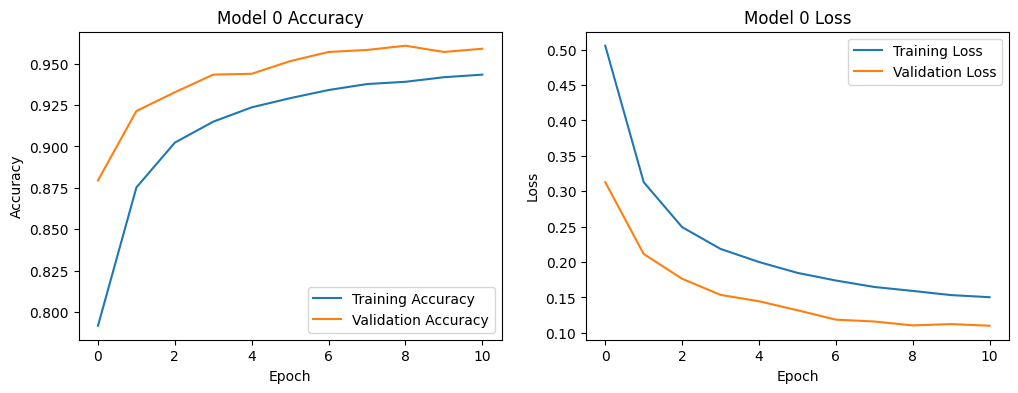


Training Model 1
Model: "tiny_conv_model_small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1960)]            0         
                                                                 
 reshape (Reshape)           (None, 49, 40, 1)         0         
                                                                 
 conv (Conv2D)               (None, 25, 20, 8)         648       
                                                                 
 relu (ReLU)                 (None, 25, 20, 8)         0         
                                                                 
 dropout (Dropout)           (None, 25, 20, 8)         0         
                                                                 
 flatten (Flatten)           (None, 4000)              0         
                                                                 
 final_fc (Dense)          

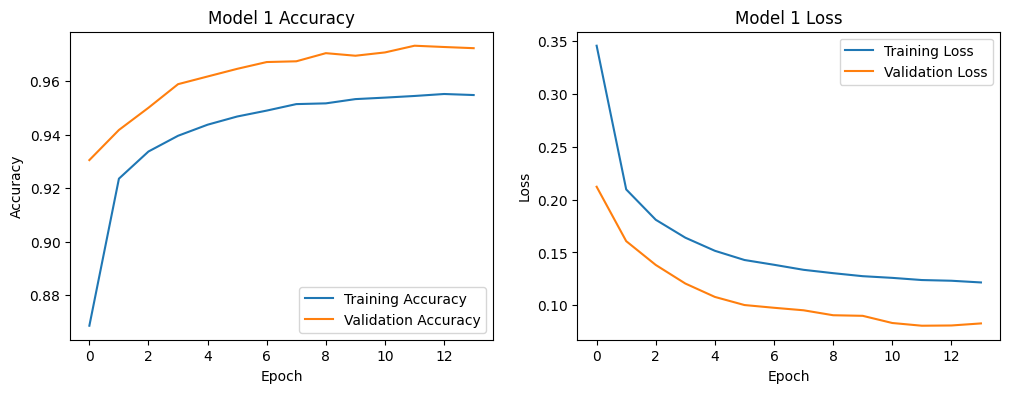

In [133]:
model_list = []
histories = []
sequential_models = True
is_training = True

for i, create_model in enumerate([create_tiny_conv_model, create_tiny_conv_model_small]):
    print(f'\nTraining Model {i}')
    model = create_model(is_training)
    
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    model.summary()


    history = model.fit(
        train_spectrogram_ds,
        validation_data = val_spectrogram_ds,
        epochs=25,  # You can adjust the number of epochs
        callbacks=keras.callbacks.EarlyStopping(verbose=1, patience=2, min_delta=0.001),
        verbose = 1
    )
    model_list.append(model)
    histories.append(history)
    
    plot_training_history(history, i)


In [134]:
for model in model_list:
    model.save(model.name + "base")
    converter = tf.lite.TFLiteConverter.from_saved_model(model.name + "base")  # Path to the SavedModel directory
    tflite_model = converter.convert()
    # Save the TensorFlow Lite model
    with open(model.name + "base.tflite", "wb") as f:
        f.write(tflite_model)


INFO:tensorflow:Assets written to: tiny_conv_modelbase/assets


INFO:tensorflow:Assets written to: tiny_conv_modelbase/assets


INFO:tensorflow:Assets written to: tiny_conv_model_smallbase/assets


INFO:tensorflow:Assets written to: tiny_conv_model_smallbase/assets


In [136]:
for model in model_list:
    test_loss, test_acc = model.evaluate(test_spectrogram_ds, verbose=0)
    print(test_loss, test_acc)

0.11226207762956619 0.9581319689750671
0.08176114410161972 0.97419673204422


## Compile and test models

In [138]:
final_models = model_list #+ new_models

In [200]:
def get_gzipped_tflite_model_size(tflite_model):
    # Write the TFLite model to a temporary file
    with tempfile.NamedTemporaryFile(suffix='.tflite', delete=False) as temp_file:
        temp_file.write(tflite_model)
        model_filename = temp_file.name

    # Compress it as a zip file for size measurement
    with tempfile.NamedTemporaryFile(suffix='.zip', delete=False) as temp_zip:
        zipped_file = temp_zip.name
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(model_filename, arcname='model.tflite')

    # Get the size of the gzipped model file in KB
    gzipped_size_kb = os.path.getsize(zipped_file) / 1000.0

    # Clean up temporary files
    os.remove(model_filename)
    os.remove(zipped_file)

    return gzipped_size_kb

def evaluate_tflite_model(tflite_model, test_dataset):
    # Convert the tf.data.Dataset to NumPy arrays if not already
    # This step assumes test_dataset yields (features, labels)
    X_list, y_list = [], []
    for x_batch, y_batch in test_dataset:
        X_list.append(x_batch.numpy())
        y_list.append(y_batch.numpy())
    X_test = np.concatenate(X_list, axis=0)
    y_test = np.concatenate(y_list, axis=0)

    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # For quantized models, manually quantize the input data from float to integer
    input_scale, input_zero_point = input_details["quantization"]

    # Reshape test data to match the input shape if necessary
    # Adjust the reshape line based on your model’s input requirements.
    # For example, if input_details['shape'] is [1, height, width, channels],
    # and X_test is [num_samples, height, width, channels], just ensure they match.
    # The snippet provided used a 2D reshape, adjust as appropriate.
    input_shape = input_details['shape']
    # Typically, input_shape[0] is 1 (batch), so we use the rest for reshape
    # Example: If input_shape is [1, 32, 32], then reshape X_test to [X_test.shape[0], 32, 32]
    # Modify this line according to your input shape.
    test_data = X_test.reshape((X_test.shape[0],) + tuple(input_shape[1:]))

    # Apply quantization scaling to test_data if quantized
    if input_scale > 0:
        test_data = test_data / input_scale + input_zero_point
    test_data = test_data.astype(input_details["dtype"])

    correct_predictions = 0
    for i in range(len(test_data)):
        # Set the input tensor. Note: if the model expects a batch dimension, 
        # you may need test_data[i:i+1] instead of test_data[i]
        interpreter.set_tensor(input_details["index"], [test_data[i]] if len(input_shape) > 1 else test_data[i])
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        top_prediction = output.argmax()
        correct_predictions += (top_prediction == y_test[i])

    accuracy = (correct_predictions / len(X_test)) if len(X_test) > 0 else 0.0
    print("tf accuracy: " + str(accuracy) )
    return accuracy


def get_tflite_accuracy(model, test_spectrogram_ds):
    # Convert to TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Evaluate the TFLite model's accuracy
    accuracy = evaluate_tflite_model(tflite_model, test_spectrogram_ds)

    # Get gzipped size of the TFLite model
    gzipped_size = get_gzipped_tflite_model_size(tflite_model)

    return accuracy, gzipped_size

In [201]:
# Function to reload any serialized models (from bytes) if necessary
def load_if_serialized(model):
    if isinstance(model, bytes):
        # Assuming the model was saved as bytes, use `tf.keras.models.model_from_json` or similar
        raise TypeError("Model is in a serialized bytes format. Please load it as a Keras model before passing.")
    return model

def get_gzipped_model_size(model):
    # Save the model to a temporary file in .keras format
    with tempfile.NamedTemporaryFile(suffix='.keras', delete=False) as temp_file:
        model.save(temp_file.name)
        model_filename = temp_file.name

    # Compress the model file to calculate its gzipped size
    with tempfile.NamedTemporaryFile(suffix='.zip', delete=False) as temp_zip:
        zipped_file = temp_zip.name
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(model_filename, arcname='model.keras')

    # Get the size of the gzipped model file in kilobytes
    gzipped_size = os.path.getsize(zipped_file) / 1000  # Convert bytes to KB

    # Clean up temporary files
    os.remove(model_filename)
    os.remove(zipped_file)

    return gzipped_size

def plot_size_v_accuracy(models, test_spectrogram_ds):
    # Lists to store the results
    accuracies = []
    model_sizes = []
    model_names = []
    tf_accuracies = []
    tf_model_sizes = []
    # Evaluate each model and store the results
    for i, model in enumerate(models, start=1):
        try:
            # Load model if it's in serialized bytes format
            model = load_if_serialized(model)

            # Check if model is a Keras model instance
            #if not isinstance(model, tf.keras.Model):
            #    raise TypeError(f"Model {i} is not a Keras model instance.")

            # Check if the model is compiled by looking for an optimizer
            if model.optimizer is None:
                model.compile(
                    optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy']
                )
            
            # Evaluate the model
            test_loss, test_acc = model.evaluate(test_spectrogram_ds, verbose=0)

            # Calculate the gzipped model size
            gzipped_size = get_gzipped_model_size(model)
            
            tf_test_acc, tf_gzipped_size = get_tflite_accuracy(model, test_spectrogram_ds)

            # Print the details
            print(f"Model {i} ({model.name}):")
            print(f"  Gzipped Model Size: {gzipped_size:.2f} KB")
            print(f"  Test Accuracy: {test_acc:.4f}")
            print(f"  TFLite Gzipped Model Size: {tf_gzipped_size:.2f} KB")
            print(f"  TFLite Test Accuracy: {tf_test_acc:.4f}")
            
            # Store the accuracy and model size
            accuracies.append(test_acc)
            model_sizes.append(gzipped_size)
            
            tf_accuracies.append(tf_test_acc)
            tf_model_sizes.append(tf_gzipped_size)
            
            model_names.append(model.name)


        except Exception as e:
            print(f"An error occurred with Model {i}: {e}")

    # Plotting accuracy vs. gzipped model size
    plt.figure(figsize=(10, 6))
    plt.plot(model_sizes, accuracies, marker='o', linestyle='', color='b')
    plt.plot(tf_model_sizes, tf_accuracies, marker='o', linestyle='', color='r')

    for i, model_name in enumerate(model_names):
        plt.text(model_sizes[i], accuracies[i], model_name, fontsize=9, ha='right', color = 'b')
        plt.text(tf_model_sizes[i], tf_accuracies[i], f"tf_{model_name}", fontsize=9, ha='right', color = 'r')
        

    # Add labels and title
    plt.xlabel('Gzipped Model Size (KB)')
    plt.ylabel('Test Accuracy')
    plt.title('Model Accuracy vs. Gzipped Model Size')
    plt.grid(True)
    plt.show()

INFO:tensorflow:Assets written to: /scratch/1482407.1.academic-gpu/tmppkbxxtyj/assets


INFO:tensorflow:Assets written to: /scratch/1482407.1.academic-gpu/tmppkbxxtyj/assets


tf accuracy: 0.9581319856874101
Model 1 (tiny_conv_model):
  Gzipped Model Size: 69.76 KB
  Test Accuracy: 0.9581
  TFLite Gzipped Model Size: 25.06 KB
  TFLite Test Accuracy: 0.9581


INFO:tensorflow:Assets written to: /scratch/1482407.1.academic-gpu/tmpcx15_lcy/assets


INFO:tensorflow:Assets written to: /scratch/1482407.1.academic-gpu/tmpcx15_lcy/assets


tf accuracy: 0.97419676122321
Model 2 (tiny_conv_model_small):
  Gzipped Model Size: 193.24 KB
  Test Accuracy: 0.9742
  TFLite Gzipped Model Size: 63.49 KB
  TFLite Test Accuracy: 0.9742


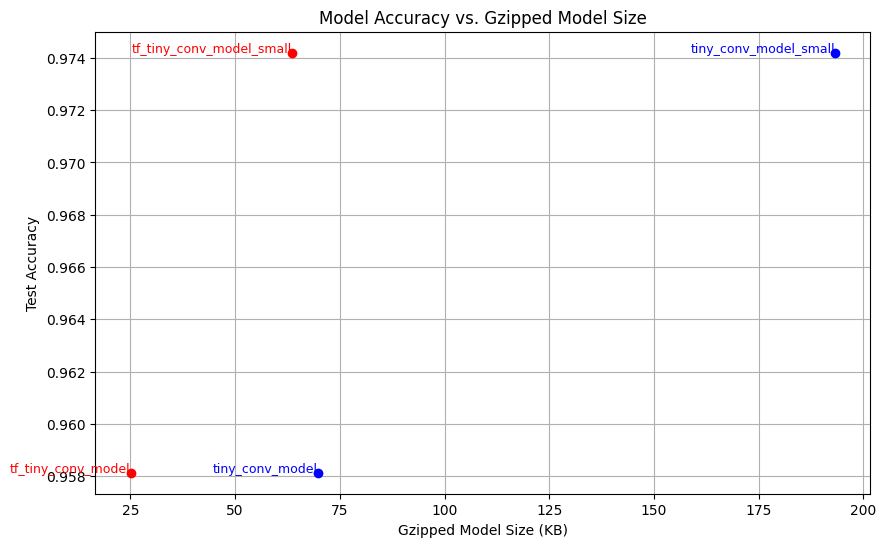

In [202]:
plot_size_v_accuracy(final_models, test_spectrogram_ds)

# Shrinking the model

[deployment on the edge](https://ai.google.dev/edge/litert)

[general model optimizations](https://www.tensorflow.org/model_optimization/guide)

We will start off with pruning

we will aslo try quantization aware training to quantize the model
and we will also try different post-training quantizations

we can also try weight clustering

and finalyl we will try a single workflow with a combination of the previous methods
[collaborative optimizations](https://www.tensorflow.org/model_optimization/guide/combine/collaborative_optimization)


https://blog.tensorflow.org/2024/04/faster-dynamically-quantized-inference-with-xnnpack.html



# Pruning

In [141]:
### Helper functions for pruning

def ds_to_numpy(dataset):
    """Converts a tf.data.Dataset to numpy arrays for data and labels."""
    data = []
    labels = []
    
    for features, label in dataset:
        data.append(features)
        labels.append(label)

    data = tf.concat(data, axis=0)
    labels = tf.concat(labels, axis=0)
    return data, labels

def print_model_weights_sparsity(model):
    """Prints the sparsity (percentage of zeros) for each layer's weights in the model."""
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):  # For pruned layers wrapped in the pruning wrapper
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            weight_np = weight.numpy()
            weight_size = weight_np.size
            zero_num = np.count_nonzero(weight_np == 0)
            print(f"{weight.name}: {zero_num / weight_size:.2%} sparsity ({zero_num}/{weight_size})")
            
def sequential_to_functional(sequential_model):
    # Extract the layers from the Sequential model
    inputs = Input(shape=sequential_model.input_shape[1:])
    x = inputs

    # Apply each layer from the Sequential model in sequence
    for layer in sequential_model.layers:
        x = layer(x)
    
    # Create a new functional model
    functional_model = Model(inputs=inputs, outputs=x)
    
    # Copy weights from the Sequential model
    functional_model.set_weights(sequential_model.get_weights())

    print(functional_model)
    
    return functional_model

In [162]:
from tensorflow.keras.models import clone_model
def prune_model(model, train_spectrogram_ds, test_spectrogram_ds):
    """Prunes the given model with optional quantization-aware training (QAT)."""
    # Ensure model is compatible with pruning by converting it to functional if needed
    #model = sequential_to_functional(model)
    
    # Convert datasets to numpy arrays
    train_data, train_labels = ds_to_numpy(train_spectrogram_ds)
    test_data, test_labels = ds_to_numpy(test_spectrogram_ds)
    
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

    # Define pruning parameters
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
    }
    
    # Define pruning callbacks
    callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]
    
    pruned_model = prune_low_magnitude(model, **pruning_params)
    
    # Compile the pruned model with a smaller learning rate for fine-tuning
    pruned_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    # Display model summary
    pruned_model.summary()
    
    # Fine-tune the pruned model
    pruned_model.fit(
        train_data,
        train_labels,
        epochs=3,
        validation_split=0.1,
        callbacks=callbacks
    )
    
    # Strip pruning wrappers for final deployment
    stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)


    # Apply pruning
    #if qat:
        # Quantization-aware training with pruning
    #    quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(model)
    #    pruned_model = tfmot.quantization.keras.quantize_apply(
    #        quant_aware_annotate_model,
    #        tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme()
    #    )
    

    # Check sparsity levels
    print_model_weights_sparsity(stripped_pruned_model)

    # Evaluate the pruned model on test data
    _, pruned_model_accuracy = pruned_model.evaluate(test_data, test_labels, verbose=0)
    print("Pruned test accuracy:", pruned_model_accuracy)

    return stripped_pruned_model

In [164]:
# Prune models and store in basic_pruned_models
basic_pruned_models = []

for model in final_models:
    # Clone the model to avoid modifying the original model
    model_name = model.name
    cloned_model = clone_model(model)
    cloned_model.set_weights(model.get_weights())  # Copy weights to the cloned model
    cloned_model._name = "pruned_"+model_name
    # Prune the cloned model
    pruned_model = prune_model(cloned_model, train_spectrogram_ds, test_spectrogram_ds)
    basic_pruned_models.append(pruned_model)

Model: "pruned_tiny_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1960)]            0         
                                                                 
 prune_low_magnitude_reshape  (None, 49, 40, 1)        1         
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_conv1 (  (None, 25, 20, 8)        1290      
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_relu1 (  (None, 25, 20, 8)        1         
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_dropout  (None, 25, 20, 8)        1         
 1 (PruneLowMagnitude)                      

INFO:tensorflow:Assets written to: /scratch/1482407.1.academic-gpu/tmpfud8a66e/assets


INFO:tensorflow:Assets written to: /scratch/1482407.1.academic-gpu/tmpfud8a66e/assets


tf accuracy: 0.9547013906820613
Model 1 (pruned_tiny_conv_model):
  Gzipped Model Size: 17.20 KB
  Test Accuracy: 0.9547
  TFLite Gzipped Model Size: 15.91 KB
  TFLite Test Accuracy: 0.9547


INFO:tensorflow:Assets written to: /scratch/1482407.1.academic-gpu/tmpu9b9cd5p/assets


INFO:tensorflow:Assets written to: /scratch/1482407.1.academic-gpu/tmpu9b9cd5p/assets


tf accuracy: 0.9662842598399055
Model 2 (pruned_tiny_conv_model_small):
  Gzipped Model Size: 40.15 KB
  Test Accuracy: 0.9663
  TFLite Gzipped Model Size: 38.18 KB
  TFLite Test Accuracy: 0.9663


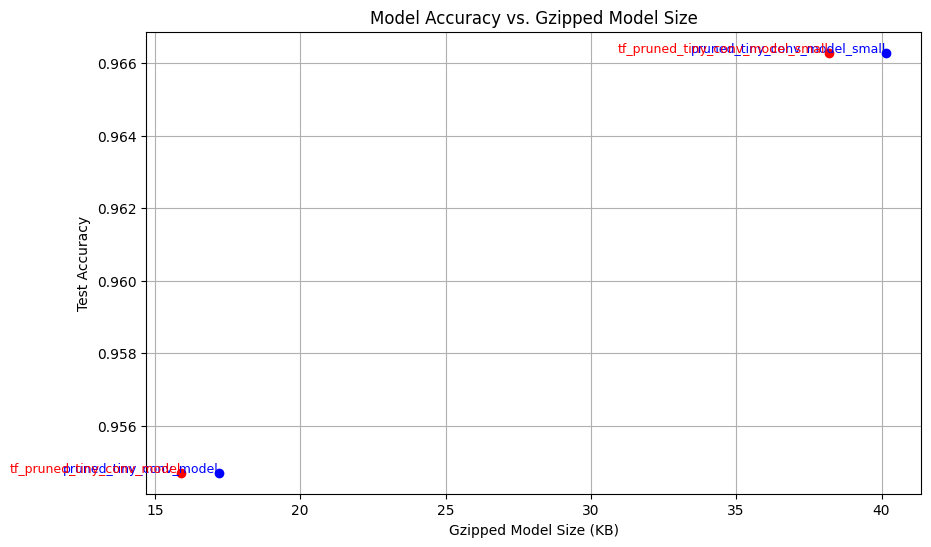

In [203]:
plot_size_v_accuracy(basic_pruned_models, test_spectrogram_ds)

# Weight Clustering

In [166]:
from tensorflow_model_optimization.python.core.clustering.keras.experimental import (
    cluster,
)

In [167]:
def cluster_model(model, train_spectrogram_ds, test_spectrogram_ds):
    train_data, train_labels = ds_to_numpy(train_spectrogram_ds)
    test_data, test_labels = ds_to_numpy(test_spectrogram_ds)
    
    cluster_weights = tfmot.clustering.keras.cluster_weights
    CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

    cluster_weights = cluster.cluster_weights

    clustering_params = {
      'number_of_clusters': 10,
      'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS,
      'preserve_sparsity': True
    }

    sparsity_clustered_model = cluster_weights(model, **clustering_params)

    sparsity_clustered_model.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    print('Train sparsity preserving clustering model:')
    sparsity_clustered_model.fit(train_data, train_labels,epochs=3, validation_split=0.1)
    
    stripped_clustered_model = tfmot.clustering.keras.strip_clustering(sparsity_clustered_model)

    return stripped_clustered_model


In [168]:
pruned_clustered_models = []

for model in basic_pruned_models:
    # Clone the model to avoid modifying the original model
    model_name = model.name
    cloned_model = clone_model(model)
    cloned_model.set_weights(model.get_weights())  # Copy weights to the cloned model
    cloned_model._name = "clustered_"+model_name
    clustered_model = cluster_model(cloned_model, train_spectrogram_ds, test_spectrogram_ds)
    pruned_clustered_models.append(clustered_model)


Train sparsity preserving clustering model:
Epoch 1/3
4575/4575 [==============================] - 19s 4ms/step - loss: 0.1176 - accuracy: 0.9561 - val_loss: 0.0987 - val_accuracy: 0.9637
Epoch 2/3
4575/4575 [==============================] - 18s 4ms/step - loss: 0.1023 - accuracy: 0.9619 - val_loss: 0.0938 - val_accuracy: 0.9644
Epoch 3/3
4575/4575 [==============================] - 17s 4ms/step - loss: 0.0958 - accuracy: 0.9649 - val_loss: 0.1025 - val_accuracy: 0.9597
Train sparsity preserving clustering model:
Epoch 1/3
4575/4575 [==============================] - 15s 3ms/step - loss: 0.0869 - accuracy: 0.9696 - val_loss: 0.0801 - val_accuracy: 0.9716
Epoch 2/3
4575/4575 [==============================] - 14s 3ms/step - loss: 0.0802 - accuracy: 0.9713 - val_loss: 0.0762 - val_accuracy: 0.9723
Epoch 3/3
4575/4575 [==============================] - 13s 3ms/step - loss: 0.0759 - accuracy: 0.9733 - val_loss: 0.0730 - val_accuracy: 0.9753


INFO:tensorflow:Assets written to: /scratch/1482407.1.academic-gpu/tmpz9h7a5w2/assets


INFO:tensorflow:Assets written to: /scratch/1482407.1.academic-gpu/tmpz9h7a5w2/assets


tf accuracy: 0.958537754989118
Model 1 (clustered_pruned_tiny_conv_model):
  Gzipped Model Size: 6.28 KB
  Test Accuracy: 0.9585
  TFLite Gzipped Model Size: 5.09 KB
  TFLite Test Accuracy: 0.9585


INFO:tensorflow:Assets written to: /scratch/1482407.1.academic-gpu/tmpc36bi_y7/assets


INFO:tensorflow:Assets written to: /scratch/1482407.1.academic-gpu/tmpc36bi_y7/assets


tf accuracy: 0.9704157290936589
Model 2 (clustered_pruned_tiny_conv_model_small):
  Gzipped Model Size: 9.85 KB
  Test Accuracy: 0.9704
  TFLite Gzipped Model Size: 8.00 KB
  TFLite Test Accuracy: 0.9704


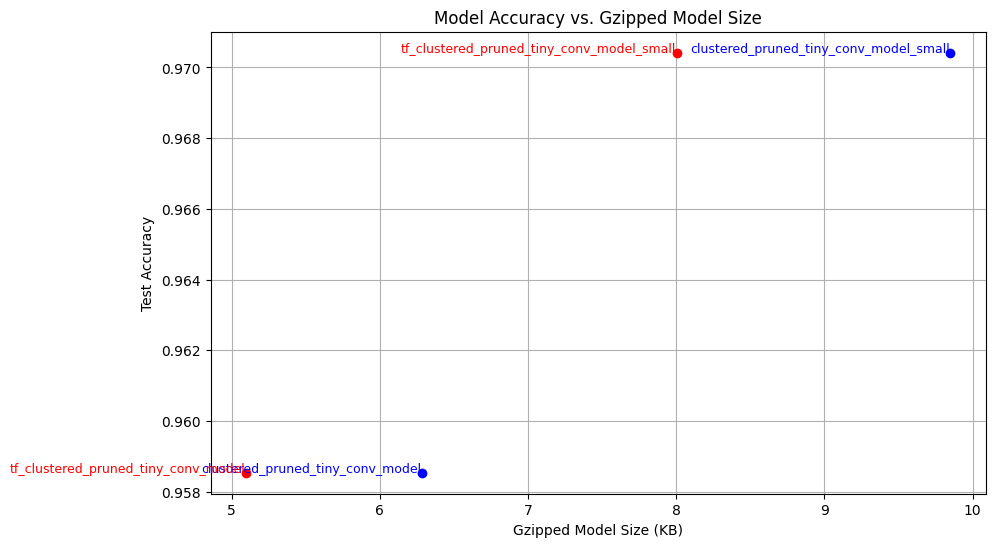

In [205]:
plot_size_v_accuracy(pruned_clustered_models, test_spectrogram_ds)

In [ ]:
'''
for model in pruned_clustered_models:
    model.save(model.name + "pc")
    converter = tf.lite.TFLiteConverter.from_saved_model(model.name + "pc")  # Path to the SavedModel directory
    tflite_model = converter.convert()
    # Save the TensorFlow Lite model
    with open(model.name + "pc.tflite", "wb") as f:
        f.write(tflite_model)

'''

## Pruning preserving quantization aware training (PQAT) and Sparsity and cluster preserving quantization aware training (PCQAT)
https://www.tensorflow.org/model_optimization/guide/combine/pqat_example
https://www.tensorflow.org/model_optimization/guide/combine/pcqat_example

## Sparsity and cluster preserving quantization aware training
https://www.tensorflow.org/model_optimization/guide/combine/pcqat_example

# Quantize models

https://www.tensorflow.org/model_optimization/guide

https://blog.tensorflow.org/2024/04/faster-dynamically-quantized-inference-with-xnnpack.html


we can also add some weight clustering?

## quantization aware training quantized models with or without pruning
https://www.tensorflow.org/model_optimization/guide/quantization/training_example

https://www.tensorflow.org/model_optimization/guide/quantization/training_comprehensive_guide#quantize_some_layers

In [ ]:
def print_model_weights_sparsity(model):
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

def print_model_weight_clusters(model):
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            # ignore auxiliary quantization weights
            if "quantize_layer" in weight.name:
                continue
            if "kernel" in weight.name:
                unique_count = len(np.unique(weight))
                print(
                    f"{layer.name}/{weight.name}: {unique_count} clusters "
                )

In [ ]:
for spectrogram, _ in train_spectrogram_ds.take(1):
    spectrogram = np.array(spectrogram, dtype=np.float32)
    for spec in spectrogram:
        print(spec.shape)

In [ ]:
#import tensorflow_model_optimization as tfmot

#quantization aware training with int8 weights and uint8 activations.
def qat(model, pruned = False, clustered = False, save = False, deployable = False):
    
    # QAT
    qat_model = tfmot.quantization.keras.quantize_model(model)

    qat_model.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    print('Train qat model:')
    
    num_batches = tf.data.experimental.cardinality(train_spectrogram_ds).numpy()

    qat_model.fit(train_spectrogram_ds, batch_size=64, epochs=1, validation_data=val_spectrogram_ds)

    # PCQAT
    quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
                  model)
    pcqat_model = tfmot.quantization.keras.quantize_apply(
                  quant_aware_annotate_model,
                  tfmot.experimental.combine.Default8BitClusterPreserveQuantizeScheme(preserve_sparsity=True))

    pcqat_model.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    print('Train pcqat model:')
    pcqat_model.fit(train_spectrogram_ds, batch_size=64, epochs=1, validation_data=val_spectrogram_ds)

    print("QAT Model clusters:")
    print_model_weight_clusters(qat_model)
    print("\nQAT Model sparsity:")
    print_model_weights_sparsity(qat_model)
    print("\nPCQAT Model clusters:")
    print_model_weight_clusters(pcqat_model)
    print("\nPCQAT Model sparsity:")
    print_model_weights_sparsity(pcqat_model)
    
    if save:
        if(not pruned and not clustered):
            model_filename = f'{model.name}'
        elif(pruned and not clustered):
            model_filename = f'pruned_{model.name}'
        elif(pruned and clustered):
            model_filename = f'pruned_clustered_{model.name}'
               
        if not deployable:
            # QAT model
            converter = tf.lite.TFLiteConverter.from_keras_model(qat_model)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            qat_tflite_model = converter.convert()
            qat_model_file = f'{model_filename}_qat_model.tflite'
            # Save the model.
            with open(qat_model_file, 'wb') as f:
                f.write(qat_tflite_model)

            # PCQAT model
            converter = tf.lite.TFLiteConverter.from_keras_model(pcqat_model)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            pcqat_tflite_model = converter.convert()
            pcqat_model_file = f'{model_filename}_pcqat_model.tflite'
            # Save the model.
            with open(pcqat_model_file, 'wb') as f:
                f.write(pcqat_tflite_model)
                
                
        if deployable:
            def representative_dataset():
                for spectrogram, _ in train_spectrogram_ds:
                    spectrogram = np.array(spectrogram, dtype=np.float32)
                    for spec in spectrogram:
                        spec_re = spec.reshape(1, 1960)
                        yield [spec_re]
                        
            # QAT model
            converter = tf.lite.TFLiteConverter.from_keras_model(qat_model)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            converter.representative_dataset = representative_dataset
            converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
            converter.inference_input_type = tf.int8
            converter.inference_output_type = tf.int8
            qat_tflite_model = converter.convert()
            qat_model_file = f'{model_filename}_qat_model.tflite'
            # Save the model.
            with open(qat_model_file, 'wb') as f:
                f.write(qat_tflite_model)

            # PCQAT model
            converter = tf.lite.TFLiteConverter.from_keras_model(pcqat_model)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            converter.representative_dataset = representative_dataset
            converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
            converter.inference_input_type = tf.int8
            converter.inference_output_type = tf.int8
            pcqat_tflite_model = converter.convert()
            pcqat_model_file = f'{model_filename}_pcqat_model.tflite'
            # Save the model.
            with open(pcqat_model_file, 'wb') as f:
                f.write(pcqat_tflite_model)


    return qat_model, pcqat_model

In [ ]:
# Evaluate the TFLite quantized model
def evaluate_tflite_model(interpreter, dataset):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    total_samples = 0
    correct_predictions = 0

    for spectrograms, labels in dataset:
        input_data = spectrograms.numpy().astype('uint8')
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        predictions = interpreter.get_tensor(output_details[0]['index'])
        predicted_labels = tf.argmax(predictions, axis=1)
        correct_predictions += tf.reduce_sum(tf.cast(predicted_labels == labels, tf.int32)).numpy()
        total_samples += labels.shape[0]

    accuracy = correct_predictions / total_samples
    return accuracy

In [ ]:
quantized_qat_models = []
pruning_quantized_qat_models = []
pruning_clustered_quantized_qat_models = []

# Do qat with non-pruned models
for model in final_models:
    qat_tflite_model, pcqat_tflite_model = qat(model, pruned = False, clustered = False, save = True, deployable = True)
    quantized_qat_models.append(qat_tflite_model)
    quantized_qat_models.append(pcqat_tflite_model)

# Do qat with pruned models
for model in basic_pruned_models:
    pruned_qat_tflite_model, pruned_pcqat_tflite_model = qat(model, pruned = True, clustered = False, save = True, deployable = False)
    pruning_quantized_qat_models.append(pruned_qat_tflite_model)
    pruning_quantized_qat_models.append(pruned_pcqat_tflite_model)

# Do qat with pruned clustered models
for model in pruned_clustered_models:
    pruned_clustered_qat_tflite_model, pruned_clustered_pcqat_tflite_model = qat(model, pruned = True,
                                                                                 clustered = True, save = True, deployable = False)
    pruning_clustered_quantized_qat_models.append(pruned_clustered_qat_tflite_model)
    pruning_clustered_quantized_qat_models.append(pruned_clustered_pcqat_tflite_model)



In [ ]:
interpreter = tf.lite.Interpreter(model_path="simple_embedding_model_qat_model.tflite")
interpreter.allocate_tensors()
# Verify input type is int8
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input type:", input_details[0]['dtype'])
print("Output type:", output_details[0]['dtype'])

In [67]:
def get_gzipped_model_file_size(file):
  # It returns the size of the gzipped model in kilobytes.

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)/1000


In [ ]:
p_and_qat_size_and_acc = {}

for model_filename in os.listdir('.'):
    if model_filename.endswith(".tflite") and ("embedding" in model_filename or "1" in model_filename):
        print(f"Model: {model_filename}")
        print(f"Size: {get_gzipped_model_size(model_filename)} KB")
        p_and_qat_size_and_acc[model_filename] = (get_gzipped_model_size(model_filename),)

In [ ]:
p_and_qat_size_and_acc

In [ ]:
def eval_model(interpreter):
    test_images, test_labels = ds_to_numpy(test_spectrogram_ds.take(100))
    #test_images, test_labels = test_spectrogram_ds.take(100)
    input_details = interpreter.get_input_details()
    input_index = input_details[0]["index"]
    input_shape = input_details[0]["shape"]  # Expected shape, e.g., [1, 1960]
    input_dtype = input_details[0]["dtype"]  # Expected input data type
    print(f"Expected input shape: {input_shape}, dtype: {input_dtype}")

    output_details = interpreter.get_output_details()
    output_index = output_details[0]["index"]

    # Run predictions on every image in the "test" dataset
    prediction_digits = []
    for i, test_image in enumerate(test_images):
        #if i % 100 == 0:
        #    print(f"Evaluated on {i} results so far.")
        # Ensure the input tensor matches the expected shape [1, 1960]
        #test_image = np.squeeze(test_image)  # Remove unnecessary dimensions
        test_image = np.expand_dims(test_image, axis=0)  # Add batch dimension
        # Convert to the expected data type
        test_image = test_image.astype(input_dtype)

        if test_image.shape != tuple(input_shape):
            test_image.reshape(tuple(input_shape))
            #raise ValueError(f"Input shape mismatch. Got {test_image.shape}, expected {input_shape}")

        interpreter.set_tensor(input_index, test_image)

        # Run inference
        interpreter.invoke()

        # Post-process the output
        output = interpreter.get_tensor(output_index)
        digit = np.argmax(output)
        prediction_digits.append(digit)

    # Compare prediction results with ground truth labels to calculate accuracy
    prediction_digits = np.array(prediction_digits)
    accuracy = np.mean(prediction_digits == test_labels)
    return accuracy


In [ ]:
#for local
#pqat_model_file = "C:\\Users\\adamk\\Downloads\\micro_speech_model_making\\notebooks\\pruned_qat_tiny_embed_conv_model.tflite"
#for SCC
root_directory = r"/projectnb/cs640grp/projects/tinyml" 


# List all TFLite files in the folder
tflite_files = [f for f in os.listdir(root_directory) if f.endswith(".tflite")]

for file_name, _ in p_and_qat_size_and_acc.items():
    # Check if file matches qat_ or pruned_qat_
    model_path = os.path.join(root_directory, file_name)
    print(f"Processing model: {model_path}")

    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path,
                                    experimental_op_resolver_type=tf.lite.experimental.OpResolverType.BUILTIN_REF)
    interpreter.allocate_tensors()

    # Evaluate model
    accuracy = eval_model(interpreter)
    if file_name in p_and_qat_size_and_acc:
        p_and_qat_size_and_acc[file_name] += (accuracy,)
    print(f"{file_name} test accuracy: {accuracy:.4f}")



#interpreter = tf.lite.Interpreter(pqat_model_file)
#interpreter.allocate_tensors()

#pqat_test_accuracy = eval_model(interpreter)

#print('Pruned and quantized TFLite test_accuracy:', pqat_test_accuracy)

In [ ]:
#size is only a bit bigger because we did not strip the model here


# Extract keys, sizes, and accuracies from the dictionary
keys = list(p_and_qat_size_and_acc.keys())
sizes = [value[0] for value in p_and_qat_size_and_acc.values()]
accuracies = [value[1] for value in p_and_qat_size_and_acc.values()]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(sizes, accuracies, color='blue', label='Models')

# Annotate each point with its corresponding model name
for i, key in enumerate(keys):
    plt.text(sizes[i], accuracies[i], key, fontsize=8, ha='right')

# Add labels, title, and grid
plt.xlabel('Model Size (KB)')
plt.ylabel('Accuracy')
plt.title('Model Size vs Accuracy')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

#size is only a bit bigger because we did not strip the model here

## Post training quantization

https://ai.google.dev/edge/litert/models/post_training_quant

In [ ]:
# Function to quantize the models using TensorFlow Lite Micro with different granularities
def quantize_model(model, optimization_strategy):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    if optimization_strategy == 'weight':
        # Quantize only weights
        converter.target_spec.supported_types = [tf.float16]
    elif optimization_strategy == 'full':
        # Full integer quantization
        def representative_dataset():
            for spectrogram, _ in train_spectrogram_ds:
                spectrogram = np.array(spectrogram, dtype=np.float32)
                yield [spectrogram]
        converter.representative_dataset = representative_dataset
        #converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
    elif optimization_strategy == 'dynamic':
        # Dynamic range quantization
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    else:
        raise ValueError("Unsupported optimization strategy. Use 'weight', 'full', or 'dynamic'.")
    tflite_model = converter.convert()
    return tflite_model

In [ ]:
# Function to quantize the models using post-training integer quantization with int16 activations and int8 weights
def quantize_model_int16x8(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    def representative_dataset():
        for spectrogram, _ in train_spectrogram_ds.take(100):
            spectrogram = np.array(spectrogram, dtype=np.float32)
            yield [spectrogram]
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
    converter.inference_input_type = tf.int16
    converter.inference_output_type = tf.int16
    tflite_model = converter.convert()
    return tflite_model

In [ ]:
for model in final_models:
    print("Model name:", model.name)

In [ ]:
# Quantize each trained model with different granularities and save them
quantization_strategies = ['weight', 'full', 'dynamic']
quantization_strategies = ['full']

for i, model in enumerate(final_models):
    for strategy in quantization_strategies:
        print(f'Quantizing Model {model.name} with {strategy} strategy')
        tflite_model = quantize_model(model, strategy)
        model_filename = f'{model.name}_{strategy}_quantized.tflite'
        with open(model_filename, 'wb') as f:
            f.write(tflite_model)
        print(f'Model {i} quantized with {strategy} strategy and saved as {model_filename}')

    # Quantize using post-training integer quantization with int16 activations and int8 weights
    #print(f'Quantizing Model {i} with int16 activations and int8 weights')
    #tflite_model_int16x8 = quantize_model_int16x8(model)
    #model_filename_int16x8 = f'model_{model}_int16x8_quantized.tflite'
    #with open(model_filename_int16x8, 'wb') as f:
    #    f.write(tflite_model_int16x8)
    #print(f'Model {i} quantized with int16 activations and int8 weights and saved as {model_filename_int16x8}')

## Quantized Model Evaluation

In [ ]:
def evaluate_quantized_model(tflite_model_path):
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    print("Input details:", input_details)
    print("Output details:", output_details)
    
    return eval_model(interpreter)


In [ ]:
# this also gets ran in the next cells
# Evaluate each quantized model
#for model_filename in os.listdir('.'):
#    if model_filename.endswith('_quantized.tflite'):
#        print(f'Evaluating Model: {model_filename}')
#        accuracy = evaluate_quantized_model(model_filename)
#        print(f'Model {model_filename} quantization accuracy: {accuracy:.4f}')



In [ ]:
# Function to print the size and memory requirements of the quantized models
def print_quantized_model_sizes(model_filenames):
    sizes = []
    for model_filename in model_filenames:
        if os.path.exists(model_filename):
            model_size = get_gzipped_model_size(model_filename)
            #model_size = os.path.getsize(model_filename) / 1000  # Size in KB
            sizes.append((model_filename, model_size))
            print(f'Model: {model_filename} Size: {model_size:.2f} KB')
        else:
            print(f'Model: {model_filename} not found.')
    return sizes

In [ ]:
# List of quantized model filenames
quantized_model_filenames = []
#for i in range(0, len(basic_pruned_models)):
#    for strategy in ['weight', 'full', 'dynamic']:
#        quantized_model_filenames.append(f'model_{i}_{strategy}_quantized.tflite')
#    quantized_model_filenames.append(f'model_{i}_int16x8_quantized.tflite')


for model_filename in os.listdir('.'):
    if model_filename.endswith('full_quantized.tflite'):
        quantized_model_filenames.append(model_filename)
        
# Print sizes of quantized models and store the sizes
print("\nQuantized Model Sizes:")
quantized_model_sizes = print_quantized_model_sizes(quantized_model_filenames)

# Evaluate each quantized model and collect accuracies
quantized_accuracies = []

for model_filename, model_size in quantized_model_sizes:
    print(f'Evaluating {model_filename}')
    accuracy = evaluate_quantized_model(model_filename)
    quantized_accuracies.append((model_filename, model_size, accuracy))
    
#print(quantized_accuracies)

# Filter accuracies for models smaller than 1000 KB and accuracy greater than 0.8
filtered_accuracies = [tup for tup in quantized_accuracies if tup[2] > 0.0 and tup[1] < 1000]

# Plot accuracy vs. model size for quantized models
model_names, model_sizes, accuracies = zip(*filtered_accuracies)

plt.figure(figsize=(10, 6))

# Plot points without connecting lines by setting linestyle='None'
plt.plot(model_sizes, accuracies, marker='o', linestyle='None', color='r')

# Annotate each point with the model name
for i, model_name in enumerate(model_names):
    plt.text(model_sizes[i], accuracies[i], model_name, fontsize=8, ha='right')

plt.xlabel('Model Size (KB)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Model Size for Quantized Models (Models < 1000 KB)')
plt.grid(True)
plt.show()


In [ ]:
def eval_model(interpreter):
    test_images, test_labels = ds_to_numpy(test_spectrogram_ds.take(100))
    #test_images, test_labels = test_spectrogram_ds.take(100)
    input_details = interpreter.get_input_details()
    input_index = input_details[0]["index"]
    input_shape = input_details[0]["shape"]  # Expected shape, e.g., [1, 1960]
    input_dtype = input_details[0]["dtype"]  # Expected input data type
    print(f"Expected input shape: {input_shape}, dtype: {input_dtype}")

    output_details = interpreter.get_output_details()
    output_index = output_details[0]["index"]

    # Run predictions on every image in the "test" dataset
    prediction_digits = []
    for i, test_image in enumerate(test_images):
        #if i % 100 == 0:
        #    print(f"Evaluated on {i} results so far.")
        # Ensure the input tensor matches the expected shape [1, 1960]
        #test_image = np.squeeze(test_image)  # Remove unnecessary dimensions
        test_image = np.expand_dims(test_image, axis=0)  # Add batch dimension
        # Convert to the expected data type
        test_image = test_image.astype(input_dtype)

        if test_image.shape != tuple(input_shape):
            test_image.resize(tuple(input_shape))
            #raise ValueError(f"Input shape mismatch. Got {test_image.shape}, expected {input_shape}")

        interpreter.set_tensor(input_index, test_image)

        # Run inference
        interpreter.invoke()

        # Post-process the output
        output = interpreter.get_tensor(output_index)
        digit = np.argmax(output)
        prediction_digits.append(digit)

    # Compare prediction results with ground truth labels to calculate accuracy
    prediction_digits = np.array(prediction_digits)
    accuracy = np.mean(prediction_digits == test_labels)
    return accuracy

In [ ]:

def plot_tflite_size_vs_accuracy(folder_path, test_spectrogram_ds): 
    test_data, test_labels = ds_to_numpy(test_spectrogram_ds.take(200))
    test_data, test_labels = test_data.numpy(), test_labels.numpy()
    # Lists to store results
    model_sizes = []
    accuracies = []
    model_names = []
    
    # Iterate through all TFLite files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".tflite"):
            model_path = os.path.join(folder_path, filename)
            model_name = os.path.splitext(filename)[0]
            
            # Get model size in KB
            model_size = get_gzipped_model_size(model_path)
            
            # Evaluate the TFLite model accuracy
            #accuracy = evaluate_tflite_model(model_path, test_data, test_labels)
            accuracy = evaluate_quantized_model(model_path)
            # Store results
            model_sizes.append(model_size)
            accuracies.append(accuracy)
            model_names.append(model_name)
            
            # Print the details
            print(f"Model: {model_name}, Size: {model_size:.2f} KB, Accuracy: {accuracy:.4f}")
    
    # Plotting accuracy vs. model size
    plt.figure(figsize=(10, 6))
    plt.plot(model_sizes, accuracies, marker='o', linestyle='', color='b')

    # Annotate each point with the model name
    for i, model_name in enumerate(model_names):
        plt.text(model_sizes[i], accuracies[i], model_name, fontsize=9, ha='right')

    # Add labels and title
    plt.xlabel('Model Size (KB)')
    plt.ylabel('Test Accuracy')
    plt.title('TFLite Model Accuracy vs. Model Size')
    plt.grid(True)
    plt.show()

    return model_sizes, accuracies, model_names


In [ ]:
model_sizes, accuracies, model_names = [], [], []
#folder_path = "C:\\Users\\adamk\\Downloads\\micro_speech_model_making\\notebooks\\"
# for scc
folder_path = "."
model_sizes, accuracies, model_names = plot_tflite_size_vs_accuracy(folder_path, test_spectrogram_ds)
# C:\Users\adamk\Downloads\micro_speech_model_making\notebooks\val_spec_ds.tfrecord

In [ ]:
def plot_filtered_model_size_vs_accuracy(model_sizes, accuracies, model_names, max_size, min_accuracy):
    # Filter models based on the provided criteria
    filtered_sizes = [size for size, acc in zip(model_sizes, accuracies) if size < max_size and acc > min_accuracy]
    filtered_accuracies = [acc for size, acc in zip(model_sizes, accuracies) if size < max_size and acc > min_accuracy]
    filtered_names = [name for size, acc, name in zip(model_sizes, accuracies, model_names) if size < max_size and acc > min_accuracy]

    # Print details of filtered models
    for size, acc, name in zip(filtered_sizes, filtered_accuracies, filtered_names):
        print(f"Name: {name}, Size: {size:.2f} KB, Accuracy: {acc:.4f}")

    # Plot only the filtered models
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_sizes, filtered_accuracies, marker='o', linestyle='', color='b', label=f"Size < {max_size} KB & Accuracy > {min_accuracy*100}%")
    
    # Annotate each filtered point with the model name
    for i, model_name in enumerate(filtered_names):
        plt.text(filtered_sizes[i], filtered_accuracies[i], model_name, fontsize=9, ha='right')

    # Add labels and title
    plt.xlabel('Model Size (KB)')
    plt.ylabel('Test Accuracy')
    plt.title(f'TFLite Model Accuracy vs. Model Size (Filtered by Size < {max_size} KB & Accuracy > {min_accuracy*100}%)')
    plt.legend()
    plt.grid(True)
    plt.show()




In [ ]:
plot_filtered_model_size_vs_accuracy(model_sizes, accuracies, model_names, max_size=40, min_accuracy=0.80)

In [ ]:
'''
def plot_filtered_model_size_vs_accuracy(model_sizes, accuracies, model_names, max_size, min_accuracy):
    # Step 1: Filter models based on the provided criteria
    filtered = [
        (size, acc, name)
        for size, acc, name in zip(model_sizes, accuracies, model_names)
        if size < max_size and acc > min_accuracy
    ]
    
    if not filtered:
        print("No models meet the filtering criteria.")
        return

    filtered_sizes = [x[0] for x in filtered]
    filtered_accuracies = [x[1] for x in filtered]
    filtered_names = [x[2] for x in filtered]

    # Step 2: Print details of filtered models
    print("Filtered Models:")
    for size, acc, name in filtered:
        print(f"Name: {name}, Size: {size:.2f} KB, Accuracy: {acc:.4f}")

    # Step 3: Categorize models based on name substrings
    group_63 = []
    group_22 = []
    group_tiny = []
    group_other = []

    for size, acc, name in filtered:
        if '63' in name:
            group_63.append((size, acc, name))
        elif '22' in name:
            group_22.append((size, acc, name))
        elif 'tiny' in name.lower():  # Using lower() to make it case-insensitive
            group_tiny.append((size, acc, name))
        else:
            group_other.append((size, acc, name))

    # Step 4: Initialize the plot
    plt.figure(figsize=(12, 8))

    # Step 5: Plot each group with a distinct color and label
    if group_63:
        sizes, accs, names = zip(*group_63)
        plt.scatter(sizes, accs, color='red', label="Generated 2")
        for i, name in enumerate(names):
            plt.text(sizes[i], accs[i], name, fontsize=9, ha='right', va='bottom', color='red')
    
    if group_22:
        sizes, accs, names = zip(*group_22)
        plt.scatter(sizes, accs, color='green', label="Generated 1")
        for i, name in enumerate(names):
            plt.text(sizes[i], accs[i], name, fontsize=9, ha='right', va='bottom', color='green')
    
    if group_tiny:
        sizes, accs, names = zip(*group_tiny)
        plt.scatter(sizes, accs, color='orange', label="Baseline")
        for i, name in enumerate(names):
            plt.text(sizes[i], accs[i], name, fontsize=9, ha='right', va='bottom', color='orange')
    
    if group_other:
        sizes, accs, names = zip(*group_other)
        plt.scatter(sizes, accs, color='blue', label="Others")
        for i, name in enumerate(names):
            plt.text(sizes[i], accs[i], name, fontsize=9, ha='right', va='bottom', color='blue')

    # Step 6: Customize the plot
    plt.xlabel('Model Size (KB)', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title(f'TFLite Model Accuracy vs. Model Size\n(Filtered by Size < {max_size} KB & Accuracy > {min_accuracy*100}%)', fontsize=14)
    plt.legend(title="Model Categories")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
'''

In [ ]:
#plot_filtered_model_size_vs_accuracy(model_sizes, accuracies, model_names, max_size=10, min_accuracy=0.90)

In [ ]:
def tflite_to_c_array(tflite_file, output_header):
    with open(tflite_file, 'rb') as f:
        data = f.read()

    array_name = 'model_data'
    with open(output_header, 'w') as f:
        f.write(f'const unsigned char {array_name}[] = {{\n  ')
        for i, byte in enumerate(data):
            f.write(f'0x{byte:02x}, ')
            if (i + 1) % 12 == 0:
                f.write('\n  ')
        f.write(f'\n}};\n')
        f.write(f'const unsigned int {array_name}_len = {len(data)};\n')


In [ ]:
# Usage
tflite_to_c_array('qat_sequential_23.tflite', 'qat_sequential_23.cc')

In [ ]:
!ls

In [ ]:
!xxd -i pruned_clustered_qat_simple_embedding_model.tflite > pcq_model.cc


In [ ]:
!xxd -i quantized_model_int8.tflite > pruned_clustered_int8.cc


In [ ]:
!xxd -i quantized_model_int8.tflite > pruned_clustered_int8.cc


In [ ]:
!xxd -i sequential_63_full_quantized.tflite > micro_model_smallest.cc


In [54]:
model_list[0]

In [56]:
basic_pruned_models[0]

In [57]:
pruned_clustered_models[0]

In [85]:
test_model = pruned_clustered_models[0]

In [86]:
test_model.summary()

Model: "tiny_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1960)]            0         
                                                                 
 reshape (Reshape)           (None, 49, 40, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 25, 20, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 25, 20, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 25, 20, 8)         0         
                                                                 
 conv2 (Conv2D)              (None, 4, 3, 8)           5128      
                                                                 
 relu2 (ReLU)                (None, 4, 3, 8)       

In [ ]:
#X_val = X_val.numpy()


In [97]:
 def deploy(model, save = True):
    ############################################
    # Step 3: Save the Model as a SavedModel
    ############################################
    saved_model_path = f"{model.name}_deployable"
    model.save(saved_model_path, save_format="tf")

    ############################################
    # Step 4: Create a Representative Dataset Function
    ############################################
    # The representative dataset provides samples to the converter
    # so it can calibrate integer scales and zero points.
    def representative_dataset_generator():
        for i in range(len(X_val)):
            # Generate random image-like data in a similar range as your real input
            # Here inputs are assumed to be normalized [0,1], but if not, adjust accordingly.
            data = np.array(X_val[i].flatten(), dtype=np.float32).reshape(1, 1960)
            yield [data]

    ############################################
    # Step 5: Convert the Model to TFLite with Full Integer Quantization
    ############################################
    converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)

    # Enable optimizations to ensure quantization is done
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Provide the representative dataset for calibration
    converter.representative_dataset = representative_dataset_generator

    # Set input and output inference types to uint8
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    # This will produce a fully quantized model (uint8)
    tflite_quant_model = converter.convert()

    # Save the quantized model to a file
    tf_path = f"{model.name}_deployable_int8.tflite"
    with open(tf_path, "wb") as f:
        f.write(tflite_quant_model)

    size = get_gzipped_model_file_size(tf_path)
    print("Model size: " + str(size))
    ############################################
    # Verification (Optional)
    ############################################
    # Load the TFLite model and check the input type
    interpreter = tf.lite.Interpreter(model_path=tf_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    print("Input details:", input_details)
    print("Output details:", output_details)
    
    if save:
        !xxd -i {tf_path} > {model.name}_deployable.cc

    return interpreter

In [98]:
interpreter = deploy(test_model)

INFO:tensorflow:Assets written to: tiny_conv_model_deployable/assets


INFO:tensorflow:Assets written to: tiny_conv_model_deployable/assets


Model size: 4.626
Input details: [{'name': 'serving_default_input:0', 'index': 0, 'shape': array([   1, 1960], dtype=int32), 'shape_signature': array([  -1, 1960], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.09361949563026428, 20), 'quantization_parameters': {'scales': array([0.0936195], dtype=float32), 'zero_points': array([20], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 21, 'shape': array([1, 4], dtype=int32), 'shape_signature': array([-1,  4], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [89]:
eval_model(interpreter)

NameError: name 'eval_model' is not defined

In [90]:
#test_data, test_label = ds_to_numpy(test_spectrogram_ds)
#test_data, test_label = test_data.numpy(), test_label.numpy()

In [ ]:
X_test = X_test.numpy()

In [187]:
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# For quantized models, manually quantize the input data from float to integer
input_scale, input_zero_point = input_details["quantization"]
test_data = X_test.reshape((X_test.shape[0], input_details['shape'][0], input_details['shape'][1]))
test_data = test_data / input_scale + input_zero_point
test_data = test_data.astype(input_details["dtype"])


In [188]:
print(input_scale)
print(input_zero_point)

0.09361949563026428
20


In [189]:
print("Input shape expected by the model:", input_details['shape'])

Input shape expected by the model: [   1 1960]


In [190]:
correct_predictions = 0
for i in range(len(test_data)):
    interpreter.set_tensor(input_details["index"], test_data[i])
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    top_prediction = output.argmax()
    correct_predictions += (top_prediction == y_test[i])

print('model accuracy is %f%% (Number of test samples=%d)' % (
    (correct_predictions * 100) / len(X_test), len(X_test)))

model accuracy is 63.106348% (Number of test samples=54218)
